# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

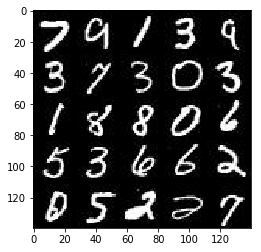

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

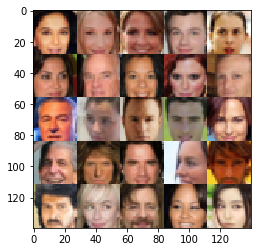

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    input_lr = tf.placeholder(tf.float32, [], name='learning_rate')

    return input_real, input_z, input_lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    alpha = 0.1

    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 16x16x64

        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x128

        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits
    
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    alpha = 0.1

    # It is weird somehow reuse needs to be not is_train here.

    with tf.variable_scope('generator', reuse=not is_train):
        x0 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x0 = tf.reshape(x0, (-1, 4, 4, 512))
        x0 = tf.layers.batch_normalization(x0, training=is_train)
        x0 = tf.maximum(alpha * x0, x0)

        x1 = tf.layers.conv2d_transpose(x0, 256, 4, strides=1, padding='valid')
        
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now

        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now

        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    num_lines_print_stats, num_lines_generate_image = 10, 150
    
    # TODO: Build Model
    print (data_shape)
    _, image_width, image_height, image_channels = data_shape
    
    inputs_real, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # Given that the 28 x 28 images are in range (-0.5, 0.5),
                # now scale data to range (-1, 1).
                batch_images *= 2.0
                
                # Sample random noise for G.
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers.
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images})

                if steps % num_lines_print_stats == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                
                    print("Epoch {}/{}, steps:{}...".format(epoch_i + 1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % num_lines_generate_image == 0:
                    show_generator_output(sess, 30, inputs_z, image_channels, data_image_mode)
      
                steps += 1               
            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2, steps:0... Discriminator Loss: 3.1451... Generator Loss: 0.0547


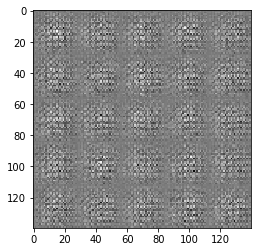

Epoch 1/2, steps:10... Discriminator Loss: 0.4031... Generator Loss: 1.3170
Epoch 1/2, steps:20... Discriminator Loss: 0.1004... Generator Loss: 3.2230
Epoch 1/2, steps:30... Discriminator Loss: 1.1935... Generator Loss: 0.4269
Epoch 1/2, steps:40... Discriminator Loss: 0.4481... Generator Loss: 1.5031
Epoch 1/2, steps:50... Discriminator Loss: 1.2577... Generator Loss: 9.1379
Epoch 1/2, steps:60... Discriminator Loss: 0.3110... Generator Loss: 6.7600
Epoch 1/2, steps:70... Discriminator Loss: 0.3427... Generator Loss: 2.0348
Epoch 1/2, steps:80... Discriminator Loss: 0.1518... Generator Loss: 2.6333
Epoch 1/2, steps:90... Discriminator Loss: 0.1116... Generator Loss: 2.3671
Epoch 1/2, steps:100... Discriminator Loss: 0.1188... Generator Loss: 3.2001
Epoch 1/2, steps:110... Discriminator Loss: 0.1440... Generator Loss: 2.8248
Epoch 1/2, steps:120... Discriminator Loss: 0.0990... Generator Loss: 4.5916
Epoch 1/2, steps:130... Discriminator Loss: 0.0640... Generator Loss: 3.6646
Epoch 1/

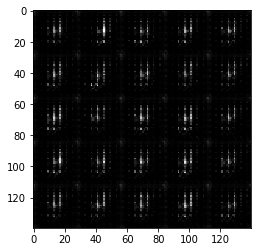

Epoch 1/2, steps:160... Discriminator Loss: 0.0500... Generator Loss: 3.7935
Epoch 1/2, steps:170... Discriminator Loss: 0.0988... Generator Loss: 3.7388
Epoch 1/2, steps:180... Discriminator Loss: 0.0730... Generator Loss: 3.9154
Epoch 1/2, steps:190... Discriminator Loss: 0.1041... Generator Loss: 4.6680
Epoch 1/2, steps:200... Discriminator Loss: 0.2514... Generator Loss: 4.4441
Epoch 1/2, steps:210... Discriminator Loss: 0.8018... Generator Loss: 1.2238
Epoch 1/2, steps:220... Discriminator Loss: 0.3267... Generator Loss: 3.1612
Epoch 1/2, steps:230... Discriminator Loss: 0.2868... Generator Loss: 2.6562
Epoch 1/2, steps:240... Discriminator Loss: 0.1830... Generator Loss: 2.9162
Epoch 1/2, steps:250... Discriminator Loss: 0.2155... Generator Loss: 2.4855
Epoch 1/2, steps:260... Discriminator Loss: 1.0304... Generator Loss: 6.3551
Epoch 1/2, steps:270... Discriminator Loss: 0.3370... Generator Loss: 2.4218
Epoch 1/2, steps:280... Discriminator Loss: 1.0784... Generator Loss: 0.7293

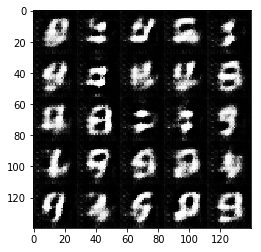

Epoch 1/2, steps:310... Discriminator Loss: 0.4508... Generator Loss: 2.0570
Epoch 1/2, steps:320... Discriminator Loss: 0.3623... Generator Loss: 2.7940
Epoch 1/2, steps:330... Discriminator Loss: 0.5804... Generator Loss: 2.1441
Epoch 1/2, steps:340... Discriminator Loss: 0.5331... Generator Loss: 2.0235
Epoch 1/2, steps:350... Discriminator Loss: 0.6261... Generator Loss: 2.3738
Epoch 1/2, steps:360... Discriminator Loss: 0.4723... Generator Loss: 1.8306
Epoch 1/2, steps:370... Discriminator Loss: 0.7467... Generator Loss: 1.2354
Epoch 1/2, steps:380... Discriminator Loss: 0.6673... Generator Loss: 1.4706
Epoch 1/2, steps:390... Discriminator Loss: 0.4973... Generator Loss: 1.7889
Epoch 1/2, steps:400... Discriminator Loss: 0.5669... Generator Loss: 1.9204
Epoch 1/2, steps:410... Discriminator Loss: 1.0405... Generator Loss: 3.1304
Epoch 1/2, steps:420... Discriminator Loss: 0.7147... Generator Loss: 1.6787
Epoch 1/2, steps:430... Discriminator Loss: 0.8476... Generator Loss: 2.3075

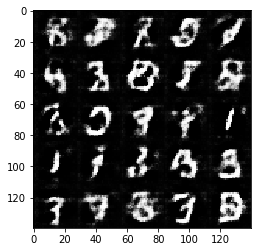

Epoch 1/2, steps:460... Discriminator Loss: 0.8081... Generator Loss: 2.2641
Epoch 2/2, steps:470... Discriminator Loss: 0.5843... Generator Loss: 1.9086
Epoch 2/2, steps:480... Discriminator Loss: 0.7272... Generator Loss: 1.3718
Epoch 2/2, steps:490... Discriminator Loss: 0.7431... Generator Loss: 1.4069
Epoch 2/2, steps:500... Discriminator Loss: 0.7825... Generator Loss: 1.4153
Epoch 2/2, steps:510... Discriminator Loss: 1.3561... Generator Loss: 2.7136
Epoch 2/2, steps:520... Discriminator Loss: 0.7790... Generator Loss: 1.2448
Epoch 2/2, steps:530... Discriminator Loss: 1.0257... Generator Loss: 2.5177
Epoch 2/2, steps:540... Discriminator Loss: 0.8801... Generator Loss: 0.8112
Epoch 2/2, steps:550... Discriminator Loss: 0.7828... Generator Loss: 1.0582
Epoch 2/2, steps:560... Discriminator Loss: 0.7752... Generator Loss: 2.0253
Epoch 2/2, steps:570... Discriminator Loss: 0.7100... Generator Loss: 1.2490
Epoch 2/2, steps:580... Discriminator Loss: 0.9054... Generator Loss: 0.7428

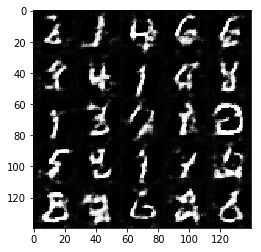

Epoch 2/2, steps:610... Discriminator Loss: 0.8017... Generator Loss: 1.0097
Epoch 2/2, steps:620... Discriminator Loss: 0.8363... Generator Loss: 0.9542
Epoch 2/2, steps:630... Discriminator Loss: 0.6922... Generator Loss: 1.2497
Epoch 2/2, steps:640... Discriminator Loss: 1.4743... Generator Loss: 0.3591
Epoch 2/2, steps:650... Discriminator Loss: 0.8715... Generator Loss: 0.8546
Epoch 2/2, steps:660... Discriminator Loss: 0.8881... Generator Loss: 0.8168
Epoch 2/2, steps:670... Discriminator Loss: 0.7474... Generator Loss: 1.9646
Epoch 2/2, steps:680... Discriminator Loss: 0.7725... Generator Loss: 1.2985
Epoch 2/2, steps:690... Discriminator Loss: 0.8093... Generator Loss: 0.8587
Epoch 2/2, steps:700... Discriminator Loss: 0.7922... Generator Loss: 1.4822
Epoch 2/2, steps:710... Discriminator Loss: 0.8423... Generator Loss: 0.9103
Epoch 2/2, steps:720... Discriminator Loss: 0.9112... Generator Loss: 2.5475
Epoch 2/2, steps:730... Discriminator Loss: 0.8856... Generator Loss: 0.7321

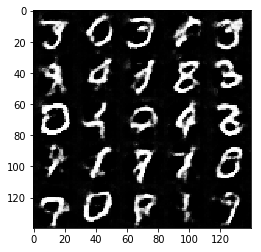

Epoch 2/2, steps:760... Discriminator Loss: 0.7957... Generator Loss: 1.1053
Epoch 2/2, steps:770... Discriminator Loss: 0.8637... Generator Loss: 0.8244
Epoch 2/2, steps:780... Discriminator Loss: 0.8048... Generator Loss: 0.8639
Epoch 2/2, steps:790... Discriminator Loss: 0.9063... Generator Loss: 2.2818
Epoch 2/2, steps:800... Discriminator Loss: 0.7076... Generator Loss: 1.4757
Epoch 2/2, steps:810... Discriminator Loss: 0.8357... Generator Loss: 0.8301
Epoch 2/2, steps:820... Discriminator Loss: 0.7555... Generator Loss: 1.5214
Epoch 2/2, steps:830... Discriminator Loss: 0.8370... Generator Loss: 0.7723
Epoch 2/2, steps:840... Discriminator Loss: 0.7699... Generator Loss: 1.4843
Epoch 2/2, steps:850... Discriminator Loss: 0.8606... Generator Loss: 1.8869
Epoch 2/2, steps:860... Discriminator Loss: 0.7712... Generator Loss: 1.1085
Epoch 2/2, steps:870... Discriminator Loss: 0.7180... Generator Loss: 1.1040
Epoch 2/2, steps:880... Discriminator Loss: 0.7592... Generator Loss: 0.9404

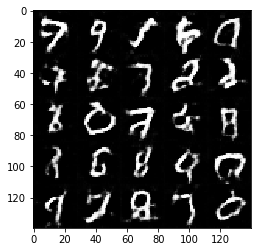

Epoch 2/2, steps:910... Discriminator Loss: 0.7259... Generator Loss: 1.7111
Epoch 2/2, steps:920... Discriminator Loss: 0.6580... Generator Loss: 1.5909
Epoch 2/2, steps:930... Discriminator Loss: 0.6260... Generator Loss: 1.2412


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1, steps:0... Discriminator Loss: 3.9485... Generator Loss: 0.0258


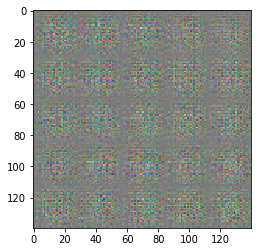

Epoch 1/1, steps:10... Discriminator Loss: 0.3233... Generator Loss: 2.1874
Epoch 1/1, steps:20... Discriminator Loss: 0.2869... Generator Loss: 2.5403
Epoch 1/1, steps:30... Discriminator Loss: 0.5781... Generator Loss: 1.0327
Epoch 1/1, steps:40... Discriminator Loss: 0.1980... Generator Loss: 2.9665
Epoch 1/1, steps:50... Discriminator Loss: 0.5438... Generator Loss: 9.0204
Epoch 1/1, steps:60... Discriminator Loss: 0.4443... Generator Loss: 5.1500
Epoch 1/1, steps:70... Discriminator Loss: 0.3131... Generator Loss: 3.2036
Epoch 1/1, steps:80... Discriminator Loss: 0.2727... Generator Loss: 5.4231
Epoch 1/1, steps:90... Discriminator Loss: 0.7261... Generator Loss: 6.3812
Epoch 1/1, steps:100... Discriminator Loss: 0.3161... Generator Loss: 1.6765
Epoch 1/1, steps:110... Discriminator Loss: 0.5999... Generator Loss: 5.1236
Epoch 1/1, steps:120... Discriminator Loss: 0.4098... Generator Loss: 1.4032
Epoch 1/1, steps:130... Discriminator Loss: 0.6236... Generator Loss: 1.5591
Epoch 1/

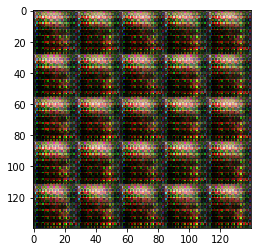

Epoch 1/1, steps:160... Discriminator Loss: 0.1201... Generator Loss: 3.0733
Epoch 1/1, steps:170... Discriminator Loss: 0.1861... Generator Loss: 2.7952
Epoch 1/1, steps:180... Discriminator Loss: 0.1543... Generator Loss: 3.0259
Epoch 1/1, steps:190... Discriminator Loss: 0.0759... Generator Loss: 3.3138
Epoch 1/1, steps:200... Discriminator Loss: 0.1378... Generator Loss: 2.6705
Epoch 1/1, steps:210... Discriminator Loss: 0.2045... Generator Loss: 2.5177
Epoch 1/1, steps:220... Discriminator Loss: 0.1426... Generator Loss: 2.9059
Epoch 1/1, steps:230... Discriminator Loss: 0.1752... Generator Loss: 2.9885
Epoch 1/1, steps:240... Discriminator Loss: 0.1629... Generator Loss: 2.9817
Epoch 1/1, steps:250... Discriminator Loss: 0.2668... Generator Loss: 3.7490
Epoch 1/1, steps:260... Discriminator Loss: 0.3184... Generator Loss: 2.6518
Epoch 1/1, steps:270... Discriminator Loss: 0.5653... Generator Loss: 2.0190
Epoch 1/1, steps:280... Discriminator Loss: 0.3953... Generator Loss: 1.8570

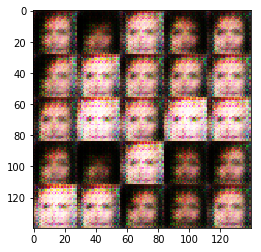

Epoch 1/1, steps:310... Discriminator Loss: 0.5083... Generator Loss: 1.5415
Epoch 1/1, steps:320... Discriminator Loss: 0.2416... Generator Loss: 3.0444
Epoch 1/1, steps:330... Discriminator Loss: 0.3347... Generator Loss: 1.6269
Epoch 1/1, steps:340... Discriminator Loss: 0.4493... Generator Loss: 1.5157
Epoch 1/1, steps:350... Discriminator Loss: 1.1866... Generator Loss: 0.4815
Epoch 1/1, steps:360... Discriminator Loss: 0.7504... Generator Loss: 4.1691
Epoch 1/1, steps:370... Discriminator Loss: 0.5892... Generator Loss: 2.9771
Epoch 1/1, steps:380... Discriminator Loss: 0.3115... Generator Loss: 2.5512
Epoch 1/1, steps:390... Discriminator Loss: 0.8636... Generator Loss: 1.7200
Epoch 1/1, steps:400... Discriminator Loss: 0.8009... Generator Loss: 1.0207
Epoch 1/1, steps:410... Discriminator Loss: 2.3467... Generator Loss: 5.4345
Epoch 1/1, steps:420... Discriminator Loss: 0.8136... Generator Loss: 1.1550
Epoch 1/1, steps:430... Discriminator Loss: 1.1609... Generator Loss: 0.8932

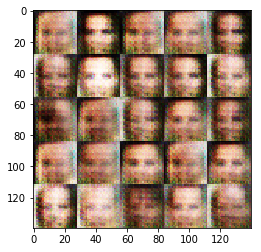

Epoch 1/1, steps:460... Discriminator Loss: 0.5092... Generator Loss: 1.6214
Epoch 1/1, steps:470... Discriminator Loss: 1.8471... Generator Loss: 3.3877
Epoch 1/1, steps:480... Discriminator Loss: 1.7439... Generator Loss: 0.4584
Epoch 1/1, steps:490... Discriminator Loss: 1.0087... Generator Loss: 0.8506
Epoch 1/1, steps:500... Discriminator Loss: 0.6296... Generator Loss: 2.1514
Epoch 1/1, steps:510... Discriminator Loss: 0.5004... Generator Loss: 1.7756
Epoch 1/1, steps:520... Discriminator Loss: 0.6928... Generator Loss: 1.4645
Epoch 1/1, steps:530... Discriminator Loss: 0.5337... Generator Loss: 2.8826
Epoch 1/1, steps:540... Discriminator Loss: 0.6127... Generator Loss: 1.7906
Epoch 1/1, steps:550... Discriminator Loss: 1.0188... Generator Loss: 1.6248
Epoch 1/1, steps:560... Discriminator Loss: 0.6214... Generator Loss: 1.6292
Epoch 1/1, steps:570... Discriminator Loss: 0.9062... Generator Loss: 1.0400
Epoch 1/1, steps:580... Discriminator Loss: 0.7804... Generator Loss: 3.4059

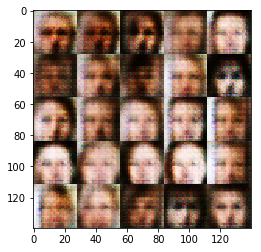

Epoch 1/1, steps:610... Discriminator Loss: 0.6793... Generator Loss: 1.1479
Epoch 1/1, steps:620... Discriminator Loss: 0.8015... Generator Loss: 3.0028
Epoch 1/1, steps:630... Discriminator Loss: 0.7992... Generator Loss: 1.5026
Epoch 1/1, steps:640... Discriminator Loss: 0.9330... Generator Loss: 0.8808
Epoch 1/1, steps:650... Discriminator Loss: 1.2767... Generator Loss: 2.5160
Epoch 1/1, steps:660... Discriminator Loss: 1.1842... Generator Loss: 0.6746
Epoch 1/1, steps:670... Discriminator Loss: 1.1111... Generator Loss: 1.3201
Epoch 1/1, steps:680... Discriminator Loss: 1.3867... Generator Loss: 0.4703
Epoch 1/1, steps:690... Discriminator Loss: 0.9041... Generator Loss: 1.2302
Epoch 1/1, steps:700... Discriminator Loss: 0.9172... Generator Loss: 0.8732
Epoch 1/1, steps:710... Discriminator Loss: 0.6752... Generator Loss: 1.4541
Epoch 1/1, steps:720... Discriminator Loss: 1.1635... Generator Loss: 0.7815
Epoch 1/1, steps:730... Discriminator Loss: 0.9510... Generator Loss: 0.8710

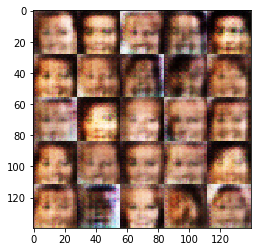

Epoch 1/1, steps:760... Discriminator Loss: 1.3072... Generator Loss: 3.1835
Epoch 1/1, steps:770... Discriminator Loss: 0.9343... Generator Loss: 0.8522
Epoch 1/1, steps:780... Discriminator Loss: 0.8416... Generator Loss: 1.1150
Epoch 1/1, steps:790... Discriminator Loss: 0.9046... Generator Loss: 1.3209
Epoch 1/1, steps:800... Discriminator Loss: 0.6631... Generator Loss: 1.7629
Epoch 1/1, steps:810... Discriminator Loss: 0.9252... Generator Loss: 1.4202
Epoch 1/1, steps:820... Discriminator Loss: 0.9272... Generator Loss: 0.8249
Epoch 1/1, steps:830... Discriminator Loss: 0.8752... Generator Loss: 1.4094
Epoch 1/1, steps:840... Discriminator Loss: 0.9506... Generator Loss: 2.3117
Epoch 1/1, steps:850... Discriminator Loss: 0.8738... Generator Loss: 1.0239
Epoch 1/1, steps:860... Discriminator Loss: 0.7686... Generator Loss: 1.3815
Epoch 1/1, steps:870... Discriminator Loss: 0.6451... Generator Loss: 2.3162
Epoch 1/1, steps:880... Discriminator Loss: 1.0614... Generator Loss: 0.8680

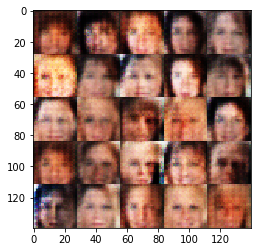

Epoch 1/1, steps:910... Discriminator Loss: 0.9589... Generator Loss: 1.3173
Epoch 1/1, steps:920... Discriminator Loss: 0.9740... Generator Loss: 0.8775
Epoch 1/1, steps:930... Discriminator Loss: 1.0282... Generator Loss: 0.7750
Epoch 1/1, steps:940... Discriminator Loss: 1.0578... Generator Loss: 0.7938
Epoch 1/1, steps:950... Discriminator Loss: 1.0915... Generator Loss: 1.4876
Epoch 1/1, steps:960... Discriminator Loss: 0.9741... Generator Loss: 0.9129
Epoch 1/1, steps:970... Discriminator Loss: 0.8534... Generator Loss: 1.2364
Epoch 1/1, steps:980... Discriminator Loss: 0.7938... Generator Loss: 1.6265
Epoch 1/1, steps:990... Discriminator Loss: 0.8811... Generator Loss: 0.9993
Epoch 1/1, steps:1000... Discriminator Loss: 0.9879... Generator Loss: 2.1999
Epoch 1/1, steps:1010... Discriminator Loss: 0.9382... Generator Loss: 1.0582
Epoch 1/1, steps:1020... Discriminator Loss: 0.9161... Generator Loss: 1.1724
Epoch 1/1, steps:1030... Discriminator Loss: 1.0604... Generator Loss: 2.

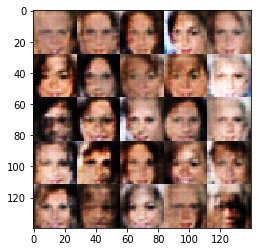

Epoch 1/1, steps:1060... Discriminator Loss: 1.1500... Generator Loss: 1.0205
Epoch 1/1, steps:1070... Discriminator Loss: 0.9066... Generator Loss: 1.3518
Epoch 1/1, steps:1080... Discriminator Loss: 0.9671... Generator Loss: 1.0946
Epoch 1/1, steps:1090... Discriminator Loss: 0.8035... Generator Loss: 1.5871
Epoch 1/1, steps:1100... Discriminator Loss: 0.9560... Generator Loss: 1.0366
Epoch 1/1, steps:1110... Discriminator Loss: 0.9927... Generator Loss: 0.7642
Epoch 1/1, steps:1120... Discriminator Loss: 0.8197... Generator Loss: 1.0806
Epoch 1/1, steps:1130... Discriminator Loss: 1.0009... Generator Loss: 1.0001
Epoch 1/1, steps:1140... Discriminator Loss: 1.2808... Generator Loss: 0.7254
Epoch 1/1, steps:1150... Discriminator Loss: 1.1030... Generator Loss: 0.7810
Epoch 1/1, steps:1160... Discriminator Loss: 1.1271... Generator Loss: 0.6010
Epoch 1/1, steps:1170... Discriminator Loss: 0.8653... Generator Loss: 1.2019
Epoch 1/1, steps:1180... Discriminator Loss: 0.9191... Generator

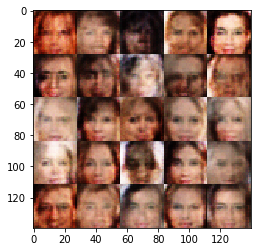

Epoch 1/1, steps:1210... Discriminator Loss: 0.8778... Generator Loss: 1.4851
Epoch 1/1, steps:1220... Discriminator Loss: 1.1906... Generator Loss: 0.5406
Epoch 1/1, steps:1230... Discriminator Loss: 0.8988... Generator Loss: 1.2982
Epoch 1/1, steps:1240... Discriminator Loss: 0.5964... Generator Loss: 1.6371
Epoch 1/1, steps:1250... Discriminator Loss: 0.8025... Generator Loss: 1.1476
Epoch 1/1, steps:1260... Discriminator Loss: 0.7350... Generator Loss: 1.6126
Epoch 1/1, steps:1270... Discriminator Loss: 1.0389... Generator Loss: 0.7757
Epoch 1/1, steps:1280... Discriminator Loss: 0.8149... Generator Loss: 1.0962
Epoch 1/1, steps:1290... Discriminator Loss: 0.9658... Generator Loss: 1.0844
Epoch 1/1, steps:1300... Discriminator Loss: 1.4024... Generator Loss: 2.1854
Epoch 1/1, steps:1310... Discriminator Loss: 1.1639... Generator Loss: 0.6895
Epoch 1/1, steps:1320... Discriminator Loss: 1.0090... Generator Loss: 0.9549
Epoch 1/1, steps:1330... Discriminator Loss: 1.0955... Generator

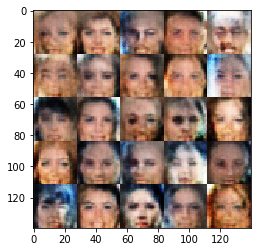

Epoch 1/1, steps:1360... Discriminator Loss: 0.9403... Generator Loss: 0.8911
Epoch 1/1, steps:1370... Discriminator Loss: 1.0621... Generator Loss: 0.6808
Epoch 1/1, steps:1380... Discriminator Loss: 0.9670... Generator Loss: 1.8045
Epoch 1/1, steps:1390... Discriminator Loss: 1.2616... Generator Loss: 0.6737
Epoch 1/1, steps:1400... Discriminator Loss: 0.8544... Generator Loss: 1.3625
Epoch 1/1, steps:1410... Discriminator Loss: 0.9523... Generator Loss: 0.7948
Epoch 1/1, steps:1420... Discriminator Loss: 1.0825... Generator Loss: 0.9643
Epoch 1/1, steps:1430... Discriminator Loss: 0.9370... Generator Loss: 1.0990
Epoch 1/1, steps:1440... Discriminator Loss: 0.7841... Generator Loss: 1.7839
Epoch 1/1, steps:1450... Discriminator Loss: 0.9977... Generator Loss: 1.2353
Epoch 1/1, steps:1460... Discriminator Loss: 0.8534... Generator Loss: 1.0788
Epoch 1/1, steps:1470... Discriminator Loss: 1.3174... Generator Loss: 0.6985
Epoch 1/1, steps:1480... Discriminator Loss: 1.1348... Generator

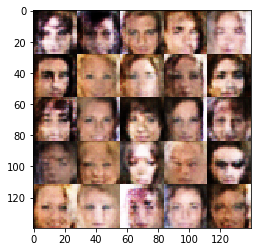

Epoch 1/1, steps:1510... Discriminator Loss: 0.9890... Generator Loss: 1.1909
Epoch 1/1, steps:1520... Discriminator Loss: 0.8986... Generator Loss: 1.3735
Epoch 1/1, steps:1530... Discriminator Loss: 0.8891... Generator Loss: 1.3831
Epoch 1/1, steps:1540... Discriminator Loss: 1.0837... Generator Loss: 0.7435
Epoch 1/1, steps:1550... Discriminator Loss: 1.0474... Generator Loss: 0.9339
Epoch 1/1, steps:1560... Discriminator Loss: 1.1097... Generator Loss: 0.6226
Epoch 1/1, steps:1570... Discriminator Loss: 0.9767... Generator Loss: 0.8804
Epoch 1/1, steps:1580... Discriminator Loss: 0.9024... Generator Loss: 1.0582


In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.